# 10. Machine Learning Model and Evaluation

#### This script trains a baseline and 'main' model on the training data and evaluates them on the test set

### Imports

In [12]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy.stats import reciprocal, uniform
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt

### Definitions

In [3]:
data_filename = 'data/MachineLearningData.csv'

baseline_model_filename = 'TrainedModels/Baseline.bin'
final_model_filename = 'TrainedModels/Final.bin'

### Defining helper function

In [4]:
def plot_confusion_matrix(targets = [], predicted = [], labels = []):
    cm = metrics.confusion_matrix(targets, predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize confusion matrix
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.rcParams["figure.figsize"] =  [15, 9]
    plt.show(block=False)

### Load Dataframe

In [5]:
# Note: We call this df_train for memory issues
df_train = pd.read_csv(data_filename).dropna()
df_train.head()

,PostID,WordCount,SentenceCount,AvgWordLength,AvgSentenceLength,UniqueWordsPercentage,URLCount,ableWords,alWords,fulWords,...,fw_by,fw_these,fw_second,fw_do,fw_shall,fw_of,fw_most,fw_mine,fw_under,fw_even
0,0.0,110,10,4.100000,11.000000,0.818182,0.009091,0.0,0.000000,0.000000,...,0.007634,0.0,0.0,0.000000,0.0,0.022901,0.0,0.0,0.000000,0.0
1,1.0,51,12,3.568627,4.250000,0.882353,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.014286,0.0,0.000000,0.0,0.0,0.000000,0.0
2,2.0,101,6,4.089109,16.833333,0.663366,0.029703,0.0,0.000000,0.009901,...,0.000000,0.0,0.0,0.008929,0.0,0.008929,0.0,0.0,0.000000,0.0
3,3.0,67,8,4.044776,8.375000,0.835821,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.012658,0.0,0.000000,0.0,0.0,0.000000,0.0
4,4.0,142,8,3.978873,17.750000,0.704225,0.014085,0.0,0.007042,0.000000,...,0.000000,0.0,0.0,0.006329,0.0,0.018987,0.0,0.0,0.006329,0.0


### Filter and split into train and test set

In [6]:
df_test = df_train[ df_train['TrainTest'] == 'test' ]

df_male = df_test[ df_test['Gender'] == 'male' ][:5000]
df_female = df_test[ df_test['Gender'] == 'female' ][:5000]
df_test = df_male.append(df_female, ignore_index=True)

y_test = df_test['Gender']
df_test = df_test.drop(['TrainTest', 'Gender', 'PostID'], axis=1)

df_train = df_train[ df_train['TrainTest'] == 'train' ]

df_male = df_train[ df_train['Gender'] == 'male' ][:5000]
df_female = df_train[ df_train['Gender'] == 'female' ][:5000]
df_train = df_male.append(df_female, ignore_index=True)

y_train = df_train['Gender']
df_train = df_train.drop(['TrainTest', 'Gender', 'PostID'], axis=1)

### Check how many train and test items there are

In [7]:
print('Number of TOTAL training examples: {0}'.format(df_train.shape[0]))
print('Number of MALE training examples: {0}'.format(np.sum(y_train == 'male' )))
print('Number of FEMALE training examples: {0}'.format(np.sum(y_train == 'female')))
print()
print('Number of TOTAL testing examples: {0}'.format(df_test.shape[0]))
print('Number of MALE testing examples: {0}'.format(np.sum(y_test == 'male')))
print('Number of FEMALE testing examples: {0}'.format(np.sum(y_test == 'female')))

Number of TOTAL training examples: 1000
Number of MALE training examples: 500
Number of FEMALE training examples: 500

Number of TOTAL testing examples: 1000
Number of MALE testing examples: 500
Number of FEMALE testing examples: 500


### Train the baseline

In [8]:
# Tune hyperparmeters by sklearn's random search
param_distributions =  {"C": uniform(0.001, 10)}

lr = LogisticRegression(penalty='l2', tol=0.0001, C=1.0,
                        fit_intercept=True, class_weight=None,
                        random_state=42, solver='newton-cg', max_iter=100, multi_class='auto',
                        verbose=1, warm_start=False, n_jobs=-1, l1_ratio=None)

# random search trough the hyperparameters
clf_search_cv = RandomizedSearchCV(lr,
                                    param_distributions,
                                    iid=False,
                                    n_iter=10,
                                    n_jobs=2,
                                    pre_dispatch='2*n_jobs',
                                    cv=5,
                                    refit=True,
                                    verbose=False, 
                                    random_state=42,
                                    return_train_score=False
                                   )

clf_search_cv.fit(df_train.iloc[:10000], y_train[:10000])

lr = clf_search_cv.best_estimator_
lr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


LogisticRegression(C=9.50814306409916, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=1,
                   warm_start=False)

In [9]:
# Train it
lr.fit(df_train, y_train)
dump(lr, baseline_model_filename)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


['TrainedModels/Baseline.bin']

### Evaluate the baseline

              precision    recall  f1-score   support

      female       0.70      0.44      0.54       500
        male       0.59      0.81      0.68       500

    accuracy                           0.63      1000
   macro avg       0.65      0.63      0.61      1000
weighted avg       0.65      0.63      0.61      1000



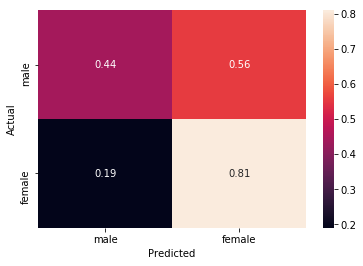

In [11]:
predictions = lr.predict(df_test)
print(metrics.classification_report(y_test, predictions))
plot_confusion_matrix(targets=y_test, predicted=predictions, labels=['male', 'female'])

### Train the main model

In [17]:
# Tune hyperparmeters by sklearn's random search
param_distributions =  {'learning_rate_init': uniform(0.0001, 0.1)}

mlp = MLPClassifier (hidden_layer_sizes=(df_train.shape[1]+100, ), activation='relu',
                     solver='adam', alpha=0.0001, batch_size='auto',
                     learning_rate='adaptive', learning_rate_init=0.001,
                     max_iter=4, shuffle=True, random_state=42,
                     tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
                     early_stopping=True, validation_fraction=0.2,
                     beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)
# random search trough the hyperparameters
clf_search_cv = RandomizedSearchCV(mlp,
                                    param_distributions,
                                    iid=False,
                                    n_iter=10,
                                    n_jobs=2,
                                    pre_dispatch='2*n_jobs',
                                    cv=5,
                                    refit=True,
                                    verbose=False, 
                                    random_state=42,
                                    return_train_score=False
                                   )

clf_search_cv.fit(df_train.iloc[:10000], y_train[:10000])

mlp = clf_search_cv.best_estimator_
mlp

/home/danielcauchi/miniconda3/envs/nlp/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(265,), learning_rate='adaptive',
              learning_rate_init=0.015701864044243653, max_iter=4, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.2, verbose=False, warm_start=False)

In [18]:
# Train it
mlp.fit(df_train, y_train)
dump(mlp, final_model_filename)

/home/danielcauchi/miniconda3/envs/nlp/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


['TrainedModels/Final.bin']

### Evauate the Final

              precision    recall  f1-score   support

      female       0.53      0.78      0.63       500
        male       0.58      0.30      0.40       500

    accuracy                           0.54      1000
   macro avg       0.56      0.54      0.52      1000
weighted avg       0.56      0.54      0.52      1000



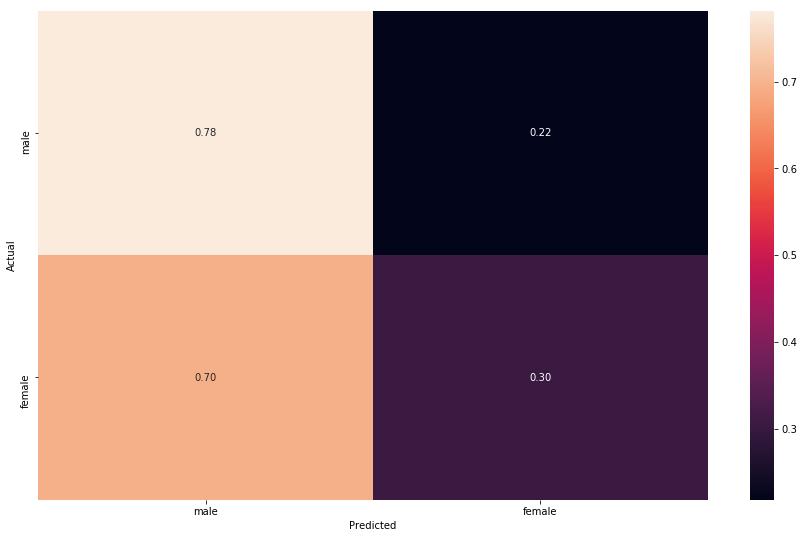

In [19]:
predictions = mlp.predict(df_test)
print(metrics.classification_report(y_test, predictions))
plot_confusion_matrix(targets=y_test, predicted=predictions, labels=['male', 'female'])